In [8]:
import time
import numpy as np
import matplotlib.pyplot as plt
from HMC_Tools import EvaluateHMC

### 1. HMC sampler

In [9]:
"""
This package implements the No-U-Turn Sampler (NUTS) algorithm 6 from the NUTS
paper (Hoffman & Gelman, 2011).

copy from https://github.com/mfouesneau/NUTS.git

reference: arXiv:1111.4246
"The No-U-Turn Sampler: Adaptively Setting Path Lengths in Hamiltonian Monte
Carlo", Matthew D. Hoffman & Andrew Gelman
"""

class nut6_hmc():
    def __init__(self, q0):
        self.q0 = q0

        self.Nq = len(q0)
        self.massinv = np.eye(self.Nq)
        self.MAX_SAMPLES = 100000

    def logp(self, x):
        return -0.5 * np.sum(x**2)

    def grad(self, x):
        return -x
    
    def f(self,x):
        return self.logp(x), self.grad(x)

    def create_p(self):
        p = np.random.normal(loc=0, scale=1.0, size=self.Nq) 
        return p
    
    def Kp(self, p):
        '''Compute Kp, as M is identical matrix. '''
        return  0.5 * p.T @ (self.massinv @p) 


    def leapfrog(self, theta, r, grad, epsilon):
    
        rprime = r + 0.5 * epsilon * grad
        thetaprime = theta + epsilon * self.massinv @ rprime
        logpprime, gradprime = self.f(thetaprime)
        rprime = rprime + 0.5 * epsilon * gradprime
        return thetaprime, rprime, gradprime, logpprime


    def find_reasonable_epsilon(self, theta0, grad0, logp0):
        """ Heuristic for choosing an initial value of epsilon """
        epsilon = 1.
        r0 = self.create_p()

        # Figure out what direction we should be moving epsilon.
        _, rprime, gradprime, logpprime = self.leapfrog(theta0, r0, grad0, epsilon)
        # brutal! This trick make sure the step is not huge leading to infinite
        # values of the likelihood. This could also help to make sure theta stays
        # within the prior domain (if any)
        k = 1.
        while np.isinf(logpprime) or np.isinf(gradprime).any():
            k *= 0.5
            _, rprime, _, logpprime = self.leapfrog(theta0, r0, grad0, epsilon * k)

        epsilon = 0.5 * k * epsilon

        logacceptprob = logpprime-logp0-(self.Kp(rprime)-self.Kp(r0))
        a = 1. if logacceptprob > np.log(0.5) else -1.
        # Keep moving epsilon in that direction until acceptprob crosses 0.5.
        # while ( (acceptprob ** a) > (2. ** (-a))):
        while a * logacceptprob > -a * np.log(2):
            epsilon = epsilon * (2. ** a)
            _, rprime, _, logpprime = self.leapfrog(theta0, r0, grad0, epsilon)
            logacceptprob = logpprime-logp0-(self.Kp(rprime)-self.Kp(r0))

        print("find_reasonable_epsilon=", epsilon)

        return epsilon


    def stop_criterion(self, thetaminus, thetaplus, rminus, rplus):
        """ Compute the stop condition in the main loop
        dot(dtheta, rminus) >= 0 & dot(dtheta, rplus >= 0)
        """
        dtheta = thetaplus - thetaminus
        return (np.dot(dtheta, rminus.T) >= 0) & (np.dot(dtheta, rplus.T) >= 0)


    def build_tree(self, theta, r, grad, logu, v, j, epsilon, joint0):
        """The main recursion."""
        if (j == 0):
            # Base case: Take a single leapfrog step in the direction v.
            thetaprime, rprime, gradprime, logpprime = self.leapfrog(theta, r, grad, v * epsilon)
            joint = logpprime - self.Kp(rprime)
            # Is the new point in the slice?
            nprime = int(logu < joint)
            # Is the simulation wildly inaccurate?
            sprime = int((logu - 1000.) < joint)
            # Set the return values---minus=plus for all things here, since the
            # "tree" is of depth 0.
            thetaminus = thetaprime[:]
            thetaplus = thetaprime[:]
            rminus = rprime[:]
            rplus = rprime[:]
            gradminus = gradprime[:]
            gradplus = gradprime[:]
            # Compute the acceptance probability.
            alphaprime = min(1., np.exp(joint - joint0))
            nalphaprime = 1
        else:
            # Recursion: Implicitly build the height j-1 left and right subtrees.
            thetaminus, rminus, gradminus, thetaplus, rplus, gradplus, thetaprime, gradprime, logpprime, nprime, sprime, alphaprime, nalphaprime = self.build_tree(theta, r, grad, logu, v, j - 1, epsilon, joint0)
            # No need to keep going if the stopping criteria were met in the first subtree.
            if (sprime == 1):
                if (v == -1):
                    thetaminus, rminus, gradminus, _, _, _, thetaprime2, gradprime2, logpprime2, nprime2, sprime2, alphaprime2, nalphaprime2 = self.build_tree(thetaminus, rminus, gradminus, logu, v, j - 1, epsilon, joint0)
                else:
                    _, _, _, thetaplus, rplus, gradplus, thetaprime2, gradprime2, logpprime2, nprime2, sprime2, alphaprime2, nalphaprime2 = self.build_tree(thetaplus, rplus, gradplus, logu, v, j - 1, epsilon, joint0)
                # Choose which subtree to propagate a sample up from.
                if (np.random.uniform() < (float(nprime2) / max(float(int(nprime) + int(nprime2)), 1.))):
                    thetaprime = thetaprime2[:]
                    gradprime = gradprime2[:]
                    logpprime = logpprime2
                # Update the number of valid points.
                nprime = int(nprime) + int(nprime2)
                # Update the stopping criterion.
                sprime = int(sprime and sprime2 and self.stop_criterion(thetaminus, thetaplus, rminus, rplus))
                # Update the acceptance probability statistics.
                alphaprime = alphaprime + alphaprime2
                nalphaprime = nalphaprime + nalphaprime2

        return thetaminus, rminus, gradminus, thetaplus, rplus, gradplus, thetaprime, gradprime, logpprime, nprime, sprime, alphaprime, nalphaprime
    


    def sampling(self, Msamples, Madapt, delta=0.6):
        """
        Implements the No-U-Turn Sampler (NUTS) algorithm 6 from from the NUTS
        paper (Hoffman & Gelman, 2011).

        Runs Madapt steps of burn-in, during which it adapts the step size
        parameter epsilon, then starts generating samples to return.

        Note the initial step size is tricky and not exactly the one from the
        initial paper.  In fact the initial step size could be given by the user in
        order to avoid potential problems

        INPUTS
        ------

        M: int
            number of samples to generate.

        Madapt: int
            the number of steps of burn-in/how long to run the dual averaging
            algorithm to fit the step size epsilon.

        delta: float
            targeted acceptance fraction

        """
        q = self.q0
        if len(np.shape(q)) > 1:
            raise ValueError('q is expected to be a 1-D array')

        samples = []
        lnprob_list = []
        logp, grad = self.f(q)   
        lnprob = logp

        # Choose a reasonable first epsilon by a simple heuristic.  Algorithm 4
        epsilon = self.find_reasonable_epsilon(q, grad, logp)

        # Parameters to the dual averaging algorithm.
        gamma = 0.05
        t0 = 10
        kappa = 0.75
        mu = np.log(10. * epsilon)

        # Initialize dual averaging algorithm.
        epsilonbar = 1
        Hbar = 0

        #for m in progress_range(1, 1000000, progress=progress):
        for m in range(1, self.MAX_SAMPLES):

            if np.mod(m,500) == 0:
                print('sampling iteration {}'.format(m))
                
            if len(samples) >= Msamples + Madapt:
                break
            
            p = self.create_p()   

            #joint = logp - 0.5 * np.dot(p, p.T)
            joint = logp - self.Kp(p)

            # resample u ~ uniform([0, exp(joint)])
            logu = float(joint - np.random.exponential(1, size=1))

            # initialize the tree
            p_left, p_right = p, p
            q_left, q_right = q, q
            grad_left, grad_right = grad, grad

            j = 0 # initial height  
            n = 1
            s = 1 # will keep going until s == 0

            while s == 1:
                # choose a direction -1 = backwards, 1 = forwards
                #v = random.uniform(-1,1)
                v = int(2 * (np.random.uniform() < 0.5) - 1)

                # double the size of the tree
                if v == -1:
                    q_left, p_left, grad_left, _,_,_, q_new, grad_new, logp_new, n_new, s_new, alpha, nalpha = self.build_tree(q_left, p_left, grad_left, logu, v, j, epsilon, joint)
                else:
                    _, _, _, q_right, p_right, grad_right, q_new, grad_new, logp_new, n_new, s_new, alpha, nalpha = self.build_tree(q_right, p_right, grad_right, logu, v, j, epsilon, joint)

                _tmp = min(1, float(n_new)/float(n))
                if s_new == 1 and (np.random.uniform() < _tmp):
                    q = q_new
                    lnprob = logp_new

                    logp = logp_new
                    grad = grad_new

                    samples.append(q)
                    lnprob_list.append(lnprob)

                # update  number of valid points we've seen
                n = n + n_new
                # decide if it's time to stop
                s = s_new and self.stop_criterion(q_left, q_right, p_left, p_right)
                # increment depth
                j = j+1      

            # Do adaptation of epsilon if we're still doing burn-in
            eta = 1 / float(m + t0)
            Hbar = (1 - eta) * Hbar + eta * (delta - alpha / float(nalpha))
            if m <= Madapt:
                epsilon = np.exp(mu - np.sqrt(m) / gamma * Hbar)
                eta = m ** -kappa
                epsilonbar = np.exp((1 - eta) * np.log(epsilonbar) + eta * np.log(epsilon))
            else:
                epsilon = epsilonbar

        print('Discrepancies between the realized average acceptance probability statistic h and its target = {}'.format(Hbar))
        samples = np.array(samples)[Madapt:,:]
        lnprob_list = lnprob_list[Madapt:]

        return samples, lnprob_list, epsilon


# Initialization

For each method, we drew 5000 sample safter 1000 burn-in samples.

In [10]:

Nq = 1000
q0 = np.random.normal(0, 1, Nq)

delta = 0.8

Msamples = 5000
Madapt = 1000

print("==============Start Sampling=============")
t_start = time.time()
print('Running HMC with dual averaging and trajectory length %0.2f...' % delta)
hmc = nut6_hmc(q0)
samples, lnprob, epsilon = hmc.sampling(Msamples, Madapt, delta)
print('Done. Final epsilon = %f.' % epsilon)

t_stop = time.time()
print("Sampling Completed in %0.2f seconds" % (t_stop - t_start))
time_cost = t_stop - t_start



==============Start Sampling=============
Running HMC with dual averaging and trajectory length 0.80...
find_reasonable_epsilon= 0.25
sampling iteration 500
sampling iteration 1000
sampling iteration 1500
Discrepancies between the realized average acceptance probability statistic h and its target = 0.010708549306351386
Done. Final epsilon = 0.325384.
Sampling Completed in 35.77 seconds


<Figure size 1000x1000 with 0 Axes>

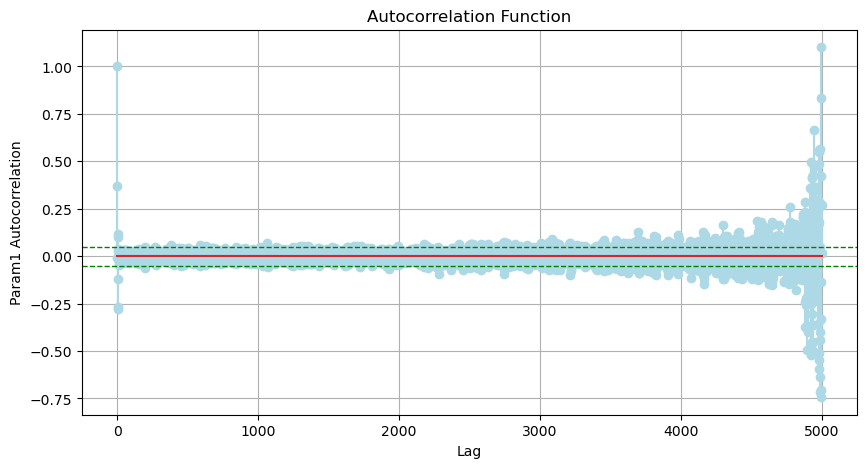

Effective Sample Size (ESS): 63.53088049562677
Time per Effective Sample Size (ESS):0.5630291549535559 second


In [13]:
max_lag=5000
data = samples[:,1]

hmc_tool = EvaluateHMC(data)
ESS = hmc_tool.effective_sample_size(max_lag)
hmc_tool.plot_autocorrelation(max_lag, label='Param1')
print("Effective Sample Size (ESS):", ESS)


TES = time_cost/ESS
print("Time per Effective Sample Size (ESS):{} second".format(TES))

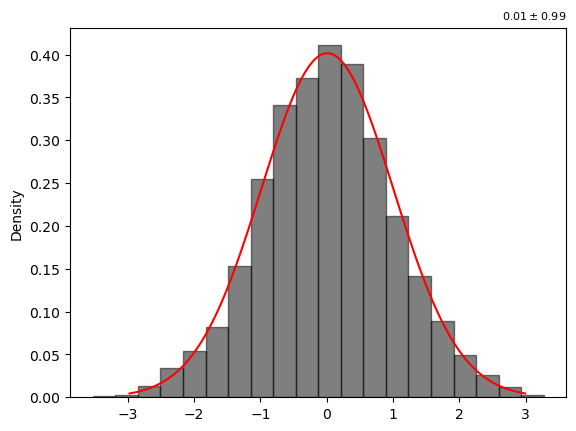

In [14]:
from scipy.stats import norm
mu, sigma = np.mean(data), np.std(data)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
gaussian = norm.pdf(x, mu, sigma)
plt.plot(x, gaussian, color='red', label='Gaussian Distribution')
plt.hist(data, bins=20,color='k',edgecolor='k',alpha=0.5,density=True)
plt.title(f'${mu:.2f} \pm {sigma:.2f}$', fontsize=8, loc='right')
plt.ylabel('Density')
plt.show()
